In [166]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pyroe
import itertools
import scipy.stats as stats
from pathlib import Path

In [167]:
def sp_corr_df(d1, d2, shared, shared_cells, kind="cells", thresh=1):
    '''
    Given 2 AnnData objects, a list of shared genes `shared` and 
    a list of shared cells `shared_cells`, compute the pariwise spearman 
    correlation of type `kind`.  If `kind` is "cells", then compute the 
    cellwise spearman correlations, if it is "genes" compute the genewise
    spearman correlations.  The result is a distribution (list) of correlation
    values.
    '''
    a = d1[shared_cells, shared].X.copy()
    b = d2[shared_cells, shared].X.copy()
    if kind == "cells":
        corrs = np.zeros(len(shared_cells))
        for i,c in enumerate(shared_cells):
            sr,p = sp.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    elif kind == "genes":
        corrs = np.zeros(len(shared))
        a = a.T.tocsr()
        b = b.T.tocsr()
        corrs = np.zeros(len(shared))
        for i,c in enumerate(shared):
            sr,p = scipy.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    return corrs

In [168]:
def get_shared(list_of_annd):
    shared_cells = list_of_annd[0].obs_names
    shared_genes = list_of_annd[0].var_names
    for annd in list_of_annd[1:]:
        shared_cells &= annd.obs_names
        shared_genes &= annd.var_names 
    return shared_cells, shared_genes

In [169]:
def read_kb(ipath):
    mpath = os.path.sep.join([ipath,'cells_x_genes.mtx'])
    gpath = os.path.sep.join([ipath,'cells_x_genes.genes.txt'])
    bpath = os.path.sep.join([ipath,'cells_x_genes.barcodes.txt'])
    
    x = scanpy.read_mtx(mpath)
    bc = pd.read_csv(bpath, names=['barcodes'])
    g = pd.read_csv(gpath, names=['gene_ids'])
    g.gene_ids = g.gene_ids.str.split('.').str.get(0)
    bc = bc.set_index('barcodes')
    g = g.set_index('gene_ids')

    x.var = g
    x.obs = bc
    
    return x 

In [170]:
def read_solo(ipath):
    mtx_path = os.path.sep.join([ipath, 'matrix.mtx.gz'])
    if not Path(mtx_path).is_file():
        mtx_path_unzipped = mtx_path.rstrip('.gz')
        if not Path(mtx_path_unzipped).is_file():
            raise f"Cannot process data at {ipath}, matrix file is missing"
        else:
            raise f"Scanpy expects the matrix, features, and genes files to be gzipped"
    
    return scanpy.read_10x_mtx(ipath, var_names="gene_ids")

In [171]:
CELLS_AXIS = 1
GENES_AXIS = 0

In [172]:
sns.set_context('talk')
sns.set_style('white')

In [173]:
mn = { 'kbd' : 'kallisto(D-list)|bustools', 'af' : 'alevin-fry(spliceu)', \
       'afi' : 'alevin-fry(splici)', 'ss' : 'STARsolo', \
       'kbd-hshmp' : 'kallisto(D-list)|bustools(HSHMP22)'
     }

In [174]:
# dictionary that will hold the different results
msn = {}

In [175]:
fs_paths = json.load(open('notebook_paths.json'))
basedir = fs_paths["mouse_brain_root_path"]
HSHMP_nascent_fasta = fs_paths["GRCm39_HSHMP_nascent_fasta"]

In [176]:
### NEW
dirs = { 
    mn['kbd'] : os.path.sep.join([basedir, 'kallisto_bustools_using_spliceu_nasecent_transcripts_results/kb_quant/adult_brain/counts_unfiltered/']),
    mn['kbd-hshmp'] : os.path.sep.join([basedir, 'kallisto_bustools_using_HSHMP_nascent_transcripts_results/kb_quant/adult_brain/counts_unfiltered/']),
    mn['ss']: os.path.sep.join([basedir, 'starsolo_results/star_quant/adult_brain/Solo.out/GeneFull/raw/']),
    mn['af'] : os.path.sep.join([basedir, 'alevin_fry_spliceu_piscem_results/af_spliceu_piscem_quant/adult_brain/af_quant/']),
    mn['afi']: os.path.sep.join([basedir, 'alevin_fry_splici_results/af_splici_quant/adult_brain/af_quant/'])
}

In [177]:
load_fn = {
    'kbd' : read_kb,
    'kbd-hshmp' : read_kb,
    'ss' : read_solo,
    'af' : lambda x : pyroe.load_fry(x, output_format={'X' : ['U', 'A'], 'spliced' : ['S'], 'unspliced' : ['U'], 'ambiguous' : ['A']}),
    'afi' : lambda x : pyroe.load_fry(x, output_format='snRNA')
}

In [178]:
!wget -O adult_barcodes.tsv https://umd.box.com/shared/static/p3v83a6oxgmfw1lcwaufkfe3dvr40qjg.tsv

--2023-01-04 00:46:23--  https://umd.box.com/shared/static/p3v83a6oxgmfw1lcwaufkfe3dvr40qjg.tsv
Resolving umd.box.com (umd.box.com)... 74.112.186.144
Connecting to umd.box.com (umd.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/p3v83a6oxgmfw1lcwaufkfe3dvr40qjg.tsv [following]
--2023-01-04 00:46:23--  https://umd.box.com/public/static/p3v83a6oxgmfw1lcwaufkfe3dvr40qjg.tsv
Reusing existing connection to umd.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://umd.app.box.com/public/static/p3v83a6oxgmfw1lcwaufkfe3dvr40qjg.tsv [following]
--2023-01-04 00:46:24--  https://umd.app.box.com/public/static/p3v83a6oxgmfw1lcwaufkfe3dvr40qjg.tsv
Resolving umd.app.box.com (umd.app.box.com)... 74.112.186.144
Connecting to umd.app.box.com (umd.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl2.boxcloud.com/d/1/b1!r

In [179]:
# high confidence barcode set 
msn_hq_cell_table = pd.read_table('adult_barcodes.tsv', names=['hq_bc'])
msn_hq_cell_table.set_index('hq_bc', inplace=True)
msn_hq_cells = msn_hq_cell_table.index

In [180]:
for k,v in mn.items():
    print(f"loading dataset for {v}")
    msn[v] = load_fn[k](dirs[v])

loading dataset for kallisto(D-list)|bustools
loading dataset for alevin-fry(spliceu)
USA mode: True
Processing user-defined output format.
Will populate output field X with sum of counts frorm ['U', 'A'].
Will combine ['S'] into output layer spliced.
Will combine ['U'] into output layer unspliced.
Will combine ['A'] into output layer ambiguous.
loading dataset for alevin-fry(splici)
USA mode: True
Using pre-defined output format: snrna
Will populate output field X with sum of counts frorm ['U', 'S', 'A'].
loading dataset for STARsolo
loading dataset for kallisto(D-list)|bustools(HSHMP22)


In [181]:
shared_cells_all, shared_genes_all = get_shared( list(msn.values()) )

In [182]:
assignment_type = pd.DataFrame.from_records(list(map(lambda x: (x, msn[mn['af']].layers[x].sum()), msn[mn['af']].layers)), \
                         columns=['UMI assignment', 'count'])
assignment_type = assignment_type.replace({'unspliced' : 'Unspliced', 'spliced' : 'Spliced', 'ambiguous' : 'Ambiguous'})

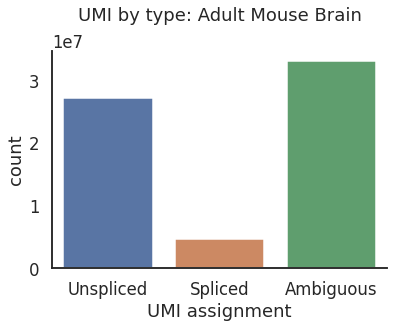

In [183]:
sns.barplot(data=assignment_type, x='UMI assignment', y='count', order=['Unspliced', 'Spliced', 'Ambiguous'])
plt.title('UMI by type: Adult Mouse Brain', pad=30)
sns.despine()
plt.savefig('plots/adult_umi_type.pdf', bbox_inches='tight')

In [184]:
HSHMP_fasta = HSHMP_nascent_fasta
strand_data = []
with open(HSHMP_fasta) as ifile:
    for l in ifile:
        if l.startswith('>'):
            toks = l.split()
            name = toks[0].strip('>')
            strand = toks[-1].strip('strand')
            strand_data.append((name, strand))

strand_df = pd.DataFrame.from_records(strand_data, columns=['name', 'strand'])
strand_df.set_index('name', inplace=True)

#### Aggregate counts by genes and cells

In [185]:
cell_umi_totals = pd.DataFrame( data= {
    mn['kbd'] : np.squeeze(np.asarray(msn[mn['kbd']][msn_hq_cells, shared_genes_all].X.sum(axis=CELLS_AXIS))),
    mn['kbd-hshmp'] : np.squeeze(np.asarray(msn[mn['kbd-hshmp']][msn_hq_cells, shared_genes_all].X.sum(axis=CELLS_AXIS))),
    mn['ss'] : np.squeeze(np.asarray(msn[mn['ss']][msn_hq_cells, shared_genes_all].X.sum(axis=CELLS_AXIS))),
    mn['af'] : np.squeeze(np.asarray(msn[mn['af']][msn_hq_cells, shared_genes_all].X.sum(axis=CELLS_AXIS))),
    mn['afi']: np.squeeze(np.asarray(msn[mn['afi']][msn_hq_cells, shared_genes_all].X.sum(axis=CELLS_AXIS)))
})

In [186]:
cell_umi_totals.corr(method='spearman')

,kallisto(D-list)|bustools,kallisto(D-list)|bustools(HSHMP22),STARsolo,alevin-fry(spliceu),alevin-fry(splici)
kallisto(D-list)|bustools,1.000000,0.985426,0.999818,0.999786,0.999876
kallisto(D-list)|bustools(HSHMP22),0.985426,1.000000,0.986625,0.985136,0.985893
STARsolo,0.999818,0.986625,1.000000,0.999566,0.999923
alevin-fry(spliceu),0.999786,0.985136,0.999566,1.000000,0.999671
alevin-fry(splici),0.999876,0.985893,0.999923,0.999671,1.000000


In [187]:
cell_umi_totals.corr(method='pearson')

,kallisto(D-list)|bustools,kallisto(D-list)|bustools(HSHMP22),STARsolo,alevin-fry(spliceu),alevin-fry(splici)
kallisto(D-list)|bustools,1.000000,0.965227,0.999736,0.999897,0.999892
kallisto(D-list)|bustools(HSHMP22),0.965227,1.000000,0.968960,0.965114,0.966795
STARsolo,0.999736,0.968960,1.000000,0.999626,0.999899
alevin-fry(spliceu),0.999897,0.965114,0.999626,1.000000,0.999796
alevin-fry(splici),0.999892,0.966795,0.999899,0.999796,1.000000


In [188]:
corr_dfs = {}

In [189]:
meth_list = list(mn.values())

In [190]:
for m1, m2 in itertools.combinations(meth_list,2):
    k = f"{m1} vs. {m2}"
    corr_dfs[k] = sp_corr_df(msn[m1], msn[m2], shared_genes_all, msn_hq_cells)

In [191]:
corr_dfs_pd = pd.DataFrame( data = corr_dfs)

In [192]:
## Set up the colors for the distribution plots below
HSHMP_cols = sorted([y for y in corr_dfs_pd.columns if y.split(' vs. ')[-1] == mn['kbd-hshmp']], \
                    key=str.lower)
other_cols = sorted(list(set(corr_dfs_pd.columns) - set(HSHMP_cols)), \
                    key=str.lower)

col_order = other_cols + HSHMP_cols

colors = dict([ (x, 'r') if x in HSHMP_cols else (x, 'gray') for x in corr_dfs_pd.columns])

In [193]:
corr_dfs_pd.to_csv('adult_mouse_brain_correlations.tsv', sep='\t')

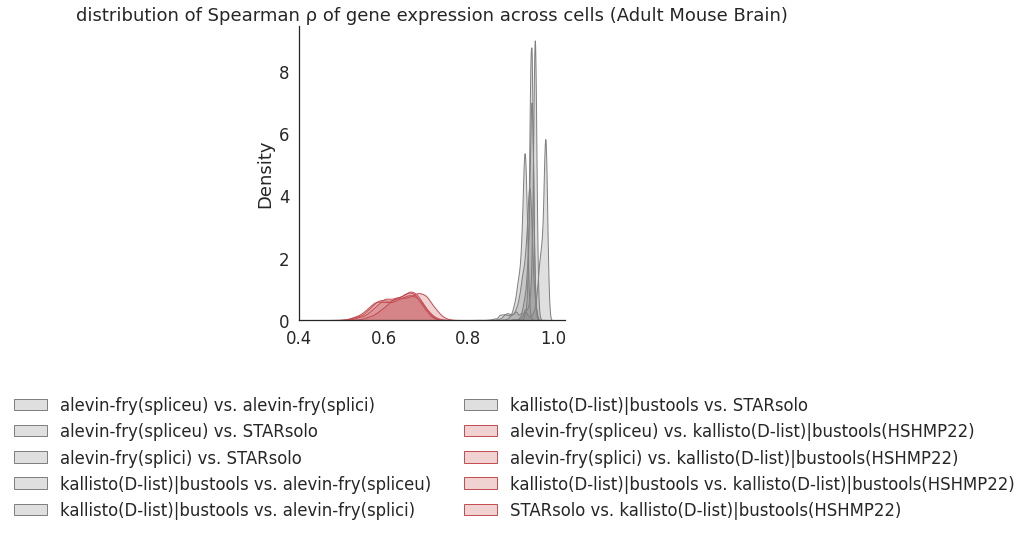

In [194]:
## plot the distributions of expresion correlations over all cells
sns.set(font_scale=1.5)
sns.set_style('white')
ax=sns.displot(corr_dfs_pd, fill=True, kind="kde", color='gray', palette=colors, hue_order=col_order)
plt.title('distribution of Spearman ρ of gene expression across cells (Adult Mouse Brain)')
sns.move_legend(
    ax, "upper center",
    bbox_to_anchor=(0.3, -0.04), ncol=2, title=None, frameon=False,
)
plt.savefig('plots/adult_spearman_dist.pdf', bbox_inches='tight')

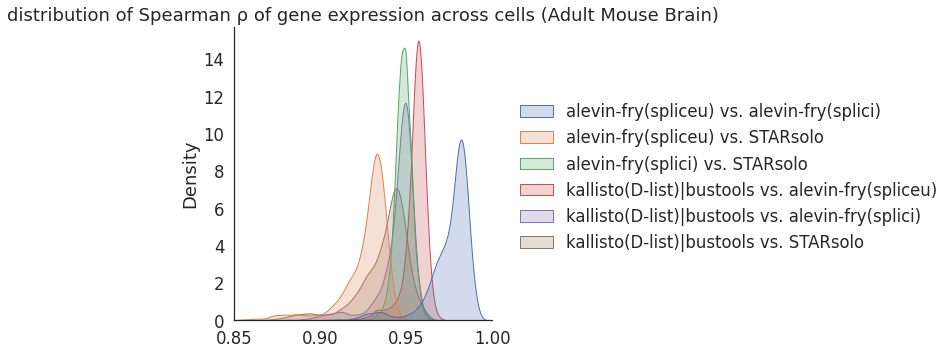

In [195]:
## plot the distributions of expresion correlations over all cells
sns.set(font_scale=1.5)
sns.set_style('white')
filt_mn = [m for m in corr_dfs.keys() if m.find(mn['kbd-hshmp']) == -1]
filt_mn = sorted(filt_mn, key=str.lower)
sns.displot(corr_dfs_pd[filt_mn], fill=True, kind="kde", hue_order=filt_mn)
plt.xlim((0.85,1))
plt.title('distribution of Spearman ρ of gene expression across cells (Adult Mouse Brain)')
plt.savefig('plots/adult_spearman_dist_no_hshmp.pdf', bbox_inches='tight')

In [196]:
gene_umi_totals = pd.DataFrame( data= dict(\
     {k : np.squeeze(np.asarray(msn[k][msn_hq_cells, shared_genes_all].X.sum(axis=GENES_AXIS))) \
     for k in msn.keys() },\
     **{ 'strand': strand_df.loc[shared_genes_all.values]['strand']}))

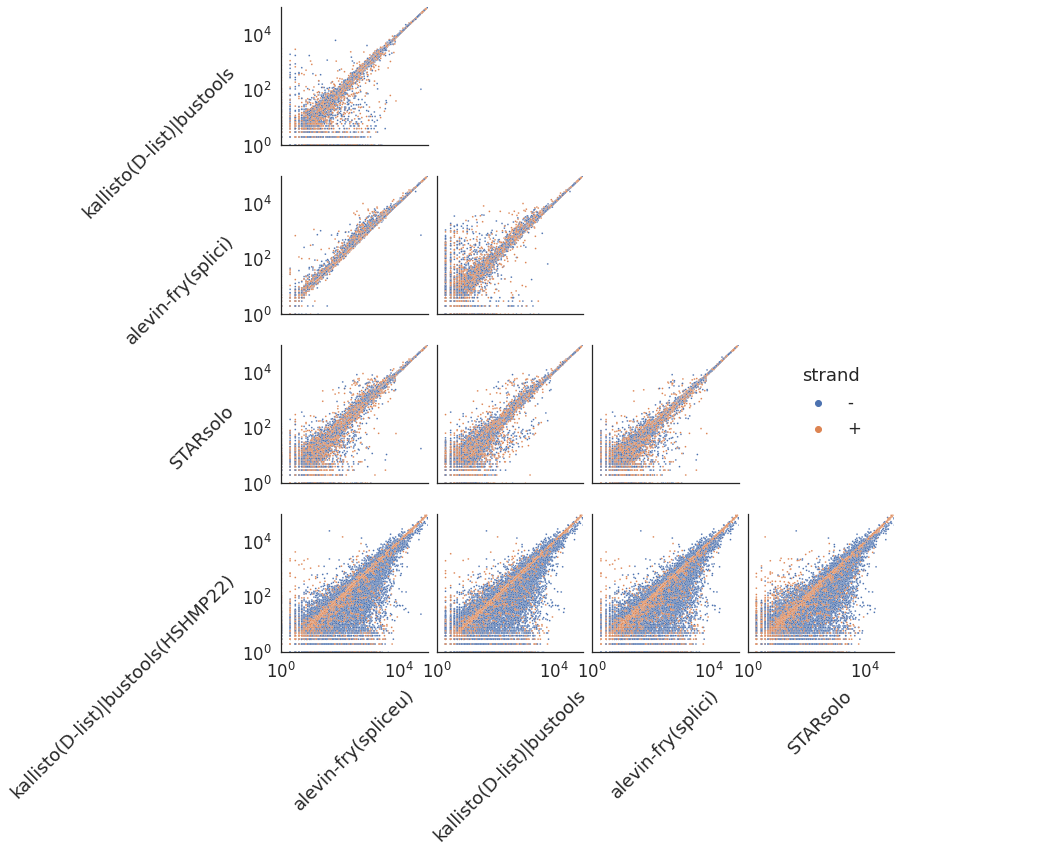

In [197]:
pp = sns.pairplot(data=\
             pd.concat([gene_umi_totals[ [mn[m] for m in ['af', 'kbd', 'kbd-hshmp', 'ss', 'afi']] ], \
                       gene_umi_totals['strand']], axis=1), \
             x_vars = [mn[m] for m in ['af', 'kbd', 'afi', 'ss', 'kbd-hshmp']],
             y_vars = [mn[m] for m in ['af', 'kbd', 'afi', 'ss', 'kbd-hshmp']],
             hue = 'strand',
             diag_kind='kde', diag_kws={"linewidth": 0, "shade": False},
             corner=True, plot_kws={'s' : 3})

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

pp.map_diag(hide_current_axis)

did_log = { 'x' : {}, 'y' : {} }
for ax in pp.axes.flatten():
    if ax is not None:
        xl = ax.get_xlabel()
        yl = ax.get_ylabel()
        if len(xl) > 0 and len(yl) > 0 and xl != yl:
            if xl not in did_log['x']:
                ax.set(xscale="log")
                ax.set_xlim((1, 100000))
                did_log['x'] = xl
            if yl not in did_log['y']:
                ax.set(yscale="log")
                ax.set_ylim((1, 100000))
                did_log['y'] = yl
        else:
            ax.set_visible(False)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)    
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=45)
        # set y labels alignment
        ax.yaxis.get_label().set_horizontalalignment('right')
pp._legend.set_bbox_to_anchor((0.9, 0.5))
plt.savefig('plots/adult_pairwise_scatter.png', bbox_inches='tight')

In [198]:
gene_umi_totals.corr(method='spearman')

,kallisto(D-list)|bustools,alevin-fry(spliceu),alevin-fry(splici),STARsolo,kallisto(D-list)|bustools(HSHMP22)
kallisto(D-list)|bustools,1.000000,0.904199,0.903199,0.959006,0.862237
alevin-fry(spliceu),0.904199,1.000000,0.997169,0.883713,0.796872
alevin-fry(splici),0.903199,0.997169,1.000000,0.882492,0.796346
STARsolo,0.959006,0.883713,0.882492,1.000000,0.839319
kallisto(D-list)|bustools(HSHMP22),0.862237,0.796872,0.796346,0.839319,1.000000


In [199]:
gene_umi_totals.corr(method='pearson')

,kallisto(D-list)|bustools,alevin-fry(spliceu),alevin-fry(splici),STARsolo,kallisto(D-list)|bustools(HSHMP22)
kallisto(D-list)|bustools,1.000000,0.999582,0.999792,0.999801,0.444789
alevin-fry(spliceu),0.999582,1.000000,0.999660,0.999543,0.433475
alevin-fry(splici),0.999792,0.999660,1.000000,0.999874,0.435217
STARsolo,0.999801,0.999543,0.999874,1.000000,0.436243
kallisto(D-list)|bustools(HSHMP22),0.444789,0.433475,0.435217,0.436243,1.000000
